# Chan Vese Segmentation

## Parameters Required
1. Chan Vese `mu` parameter
2. Contour Area Threshold

In [1]:
import os
os.chdir('..')

In [2]:
from utils.data import get_training_data_for_image_set, extract_contour_bounding_box_masked
from utils.visualize import display_instances_segments
import lung_map_utils
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import chan_vese, mark_boundaries
%matplotlib inline
a = get_training_data_for_image_set('data/image_set_90')
hsv_img = a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['hsv_img']
sub = extract_contour_bounding_box_masked(
    cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB),
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['regions'][2]['points']
)
sub_hsv = extract_contour_bounding_box_masked(
    hsv_img,
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['regions'][2]['points']
)

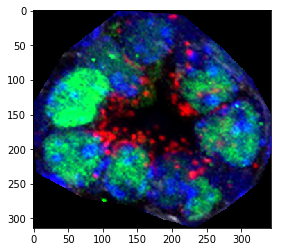

In [3]:
plt.imshow(sub)

### Chan Vese 
The method is designed to work on grayscale images. 

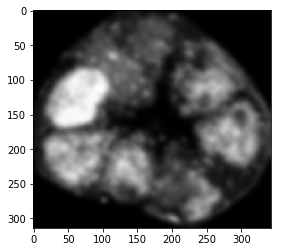

In [4]:
sub_blur = cv2.GaussianBlur(sub, (21,21), 0)
sub_gray = cv2.cvtColor(sub_blur,cv2.COLOR_RGB2GRAY)
plt.imshow(sub_gray, cmap='gray')

In [5]:
segments = chan_vese(sub_gray, mu=0.1)

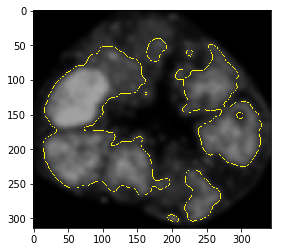

In [6]:
plt.imshow(mark_boundaries(sub_gray, segments))

> Hmm, this does a pretty good job. Let's see if we can't come up with some rules that will "pinch" off some segments. But first, what is the `segments` object?

In [7]:
segs = segments*1

In [8]:
segs.astype('uint8')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [9]:
masked_sub = cv2.bitwise_and(sub, sub, mask=segs.astype('uint8'))

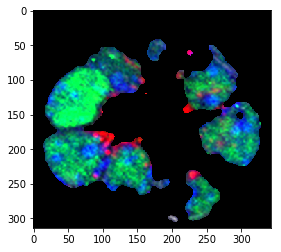

In [10]:
plt.imshow(masked_sub)

In [13]:
_, contours, hierarchy = cv2.findContours(segs.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Found {} contours.".format(str(len(contours))))

Found 7 contours.


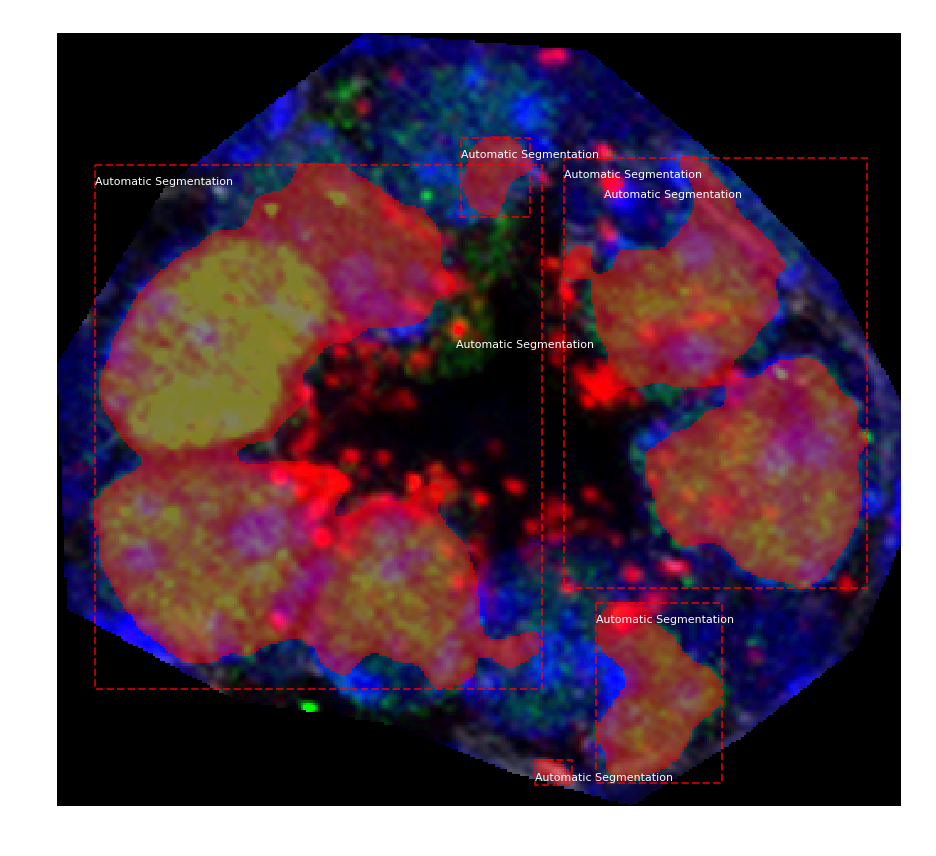

In [14]:
results = []
for contour in contours:
    results.append({'points': contour})

display_instances_segments(
    sub,
    results,
    ['raw']
)

In [15]:
def contour_area_thresholding(list_of_contours, area_thresh=(21*21)):
    results_list = []
    results_dict = []
    for contour in list_of_contours:
        area = cv2.contourArea(contour)
        if area>=area_thresh:
            results_dict.append({'points': contour})
            results_list.append(contour)
    return results_list, results_dict

In [ ]:
contours_thresh_list, contours_thresh_dict = contour_area_thresholding(contours)
print("{} contours left after thresholding".format(str(len(contours_thresh_list))))

In [ ]:
display_instances_segments(
    sub,
    contours_thresh_dict,
    ['raw']
)

> Now instead of merging contours together, it appears that we want to try to "pinch them off". We try to identify an automatic approach to such a problem

# Whole Image View

In [ ]:
from utils.cell_segmentation import chan_vese_segmentation

In [ ]:
all_contours = chan_vese_segmentation(
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['hsv_img'],
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['regions']
)

> **NOTE** this takes a LONG time to run!

In [ ]:
results = []
for contour in all_contours:
    results.append({'points': contour})

In [ ]:
rgb_image = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
display_instances_segments(
    rgb_image,
    results,
    ['raw'],
    title='Color Based Segments: {} Cells found'.format(str(len(all_contours)))
)